##### Student information:
- Name: Tuan Anh NGUYEN
- Email: tuan.nguyen@etu.univ-cotedazur.fr

---

## Project Description

### 1. Objective
The aim of this project is to propose both a Machine Learning (ML) model and a Deep Learning (DL) model capable of filling in the attendance sheet after taking a photo of the classroom.

### 2. Allowed Resources
Everything covered in the ML and DL courses can be used.

### 3. Dataset Preparation
- Detail the process of building training datasets to recognize people.
- For the ML approach, pre-processing of the image (e.g., segmentation) can leverage Deep Learning methods.

### 4. Steps
1. **Face Detection:** Identify faces in the image and determine the number of people in the room (segmentation problem).
2. **Gender Recognition:** Classify the gender of each detected face. (For this project, I think it does not need 'Gender Recognition')
3. **Identity Recognition:** Identify each person in the image (describe the exact method and constraints).

### 5. Additional Notes
- External datasets can be used for training or fine-tuning parts of the project.
- The project deliverables include:
  - A Jupyter Notebook implementing the proposed solution.
  - A scientific article (5 to 10 pages) presenting the methodology, strengths, and limitations, with references.
  - Ethical considerations can be referenced based on the ethics lecture.
---



### Stractegic Plan of Action for Machine Learning Approach:

1. *Data Prepairing*

2. *Model Building*

3. *Result*

4. *Task Outcomes & Conclusion*

## Imports

In [12]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import xgboost as xgb
import face_alignment

import os
import random
import cv2

from ultralytics import YOLO

import pandas as pd

import torch
from torchvision.models import vgg16, VGG16_Weights, resnet34, ResNet34_Weights
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


 --- 
### <center> 1. Data Prepairing
 ---

#### 1.1. Build dataset

- Load images from the dataset. I had built this dataset based on the video and images of classmates with their permission.

In [3]:
input_folder = r'C:\Users\Admin\Master Program\Projects\Project_2\img\Class'

# Get the faces images
count = 0
faces_data_dict = {}
person_label_dict = {}
for person_folder in os.listdir(input_folder):
    person_folder_path = os.path.join(input_folder, person_folder)
    person_label_dict[count] = person_folder
    lst_faces_img = []
    for filename in os.listdir(person_folder_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            img_path = os.path.join(person_folder_path, filename)
            lst_faces_img.append(img_path)

    faces_data_dict[count] = lst_faces_img
    count +=1

print(person_label_dict)

{0: 'Abinav', 1: 'Arion', 2: 'Dialo', 3: 'Eli', 4: 'Gerard', 5: 'Hadi', 6: 'Hasham', 7: 'Hassan', 8: 'Ismail', 9: 'Juliana', 10: 'Melissa', 11: 'Nabila', 12: 'Nestor', 13: 'Tuan', 14: 'Tuan Anh', 15: 'Ubaid', 16: 'Usman', 17: 'Youssef', 18: 'Zahid', 19: 'Zeev'}


- Create a dictionary to map the path of image files with coressponding labels

In [4]:
images_labels_dict = {img:k for k,v in faces_data_dict.items() for img in v}
images = list(images_labels_dict.keys())
random.shuffle(images)
faces_dataset = [(x, images_labels_dict[x]) for x in images]
print(len(faces_dataset))
print(faces_dataset[0])

4006
('C:\\Users\\Admin\\Master Program\\Projects\\Project_2\\img\\Class\\Tuan\\face_44_11.jpg', 13)


- Function to load the data. Here, I moved the axis from (H,W,C) to (C,H,W) to fit the preprocessing pipeline

In [5]:
def load_data(dataset):
    X = []
    y = []
    for image_path, label in dataset:
        img = cv2.imread(image_path)
        img_RBG = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        img_resized = cv2.resize(img_RBG, (224,224), interpolation=cv2.INTER_LINEAR)
        # print(img.shape)
        X.append(img_resized)
        y.append(label)

    return np.array(X), np.array(y)

X, y = load_data(faces_dataset)

- Function to extract the facial landmark points

In [6]:
def extract_landmark(images, labels=None):
    # Load the Face Alignment model
    face_alignment_model = face_alignment.FaceAlignment(face_alignment.LandmarksType.TWO_D)
    landmarks_X = []
    landmarks_y = []
    if labels is not None:
        for idx, (img, label) in enumerate(zip(images,labels)):
            pred = face_alignment_model.get_landmarks_from_image(img)
            if pred:
                landmarks_X.append(pred[0])
                landmarks_y.append(label)
        return np.array(landmarks_X), np.array(landmarks_y)
    else:
        for idx, img in enumerate(images):
            pred = face_alignment_model.get_landmarks_from_image(img)
            if pred:
                landmarks_X.append(pred[0])
        return np.array(landmarks_X)

In [7]:
X_landmark, y_landmark = extract_landmark(X, y)
print("X_landmark shape: ", X_landmark.shape)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\face_alignment\api.py:147: UserWarning: No faces were detected.
  warnings.warn("No faces were detected.")


X_landmark shape:  (3977, 68, 2)


#### 1.2. Compute the face distances

- Build the function to compute the face distances, inter-distances based on the facial landmark points

In [8]:
def compute_face_distances(landmarks):
    distances = {}

    # Jawline
    distances["face_width"] = np.linalg.norm(landmarks[0] - landmarks[16])
    distances["chin_to_left_jaw"] = np.linalg.norm(landmarks[8] - landmarks[4])
    distances["chin_to_right_jaw"] = np.linalg.norm(landmarks[8] - landmarks[12])

    # Eyes
    right_eye_center = np.mean(landmarks[36:42], axis=0)
    left_eye_center = np.mean(landmarks[42:48], axis=0)
    distances["inter_eye_distance"] = np.linalg.norm(right_eye_center - left_eye_center)
    distances["right_eye_width"] = np.linalg.norm(landmarks[36] - landmarks[39])
    distances["left_eye_width"] = np.linalg.norm(landmarks[42] - landmarks[45])

    # Nose
    distances["nose_width"] = np.linalg.norm(landmarks[31] - landmarks[35])
    distances["nose_length"] = np.linalg.norm(landmarks[30] - landmarks[33])

    # Mouth
    distances["mouth_width"] = np.linalg.norm(landmarks[48] - landmarks[54])
    distances["mouth_height"] = np.linalg.norm(landmarks[51] - landmarks[57])
    
     # Nose to other regions
    distances["nose_tip_to_chin"] = np.linalg.norm(landmarks[30] - landmarks[8])
    distances["nose_base_to_mouth_center"] = np.linalg.norm(landmarks[33] - landmarks[51])
    distances["nose_tip_to_left_eye_inner"] = np.linalg.norm(landmarks[30] - landmarks[39])
    distances["nose_tip_to_right_eye_inner"] = np.linalg.norm(landmarks[30] - landmarks[42])

    # Eyes to other regions
    right_eye_center = np.mean(landmarks[36:42], axis=0)
    left_eye_center = np.mean(landmarks[42:48], axis=0)
    distances["right_eye_center_to_jaw"] = np.linalg.norm(right_eye_center - landmarks[3])
    distances["left_eye_center_to_jaw"] = np.linalg.norm(left_eye_center - landmarks[13])
    distances["right_eye_outer_to_eyebrow"] = np.linalg.norm(landmarks[36] - landmarks[17])
    distances["left_eye_outer_to_eyebrow"] = np.linalg.norm(landmarks[45] - landmarks[26])

    # Eyebrows to other regions
    distances["right_eyebrow_mid_to_jaw"] = np.linalg.norm(landmarks[19] - landmarks[4])
    distances["left_eyebrow_mid_to_jaw"] = np.linalg.norm(landmarks[24] - landmarks[12])
    distances["right_eyebrow_outer_to_mouth"] = np.linalg.norm(landmarks[17] - landmarks[48])
    distances["left_eyebrow_outer_to_mouth"] = np.linalg.norm(landmarks[26] - landmarks[54])

    # Mouth to jawline
    distances["right_mouth_corner_to_jaw"] = np.linalg.norm(landmarks[48] - landmarks[4])
    distances["left_mouth_corner_to_jaw"] = np.linalg.norm(landmarks[54] - landmarks[12])
    distances["upper_lip_to_chin"] = np.linalg.norm(landmarks[51] - landmarks[8])
    
    
    face_width = distances["face_width"]
    normalized_distances = {k: v / face_width for k, v in distances.items()}

    return list(normalized_distances.values())

X_distances = np.array([compute_face_distances(x) for x in X_landmark])

print("X_distance shape: ", X_distances.shape)

X_distance shape:  (3977, 25)


#### 1.3. Prepare the data for training steps

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_distances, y_landmark, test_size=0.2, random_state=1)
x_train = X_train.reshape(X_train.shape[0], -1)
x_val = X_val.reshape(X_val.shape[0], -1)

In [10]:
print("X_train shape: ", x_train.shape)
print("X_val shape: ", x_val.shape)

X_train shape:  (3181, 25)
X_val shape:  (796, 25)


 --- 
### <center> 2. Predictive Modeling
 ---

##### 2.1. Build the training model 

In [11]:
pipe = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    # ('pca', PCA(0.95)),
    ('svm', SVC(C=100, kernel='rbf', decision_function_shape='ovo'))
])
params = {
    # "pca__n_components":[0.9,0.95],
    "svm__C":[10,50,100],
    "svm__kernel":['linear','rbf','sigmoid'],
    "svm__decision_function_shape":['ovo', 'ovr']
}
clf = GridSearchCV(pipe, params, cv=3)
clf.fit(x_train, y_train)

print("Best hyperparameters: ", clf.best_params_)

Best hyperparameters:  {'svm__C': 100, 'svm__decision_function_shape': 'ovo', 'svm__kernel': 'rbf'}


#### 2.2 Evaluate model

In [13]:
y_pred = clf.best_estimator_.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.21      0.17        34
           1       0.46      0.49      0.47        43
           2       0.40      0.50      0.44        36
           3       0.41      0.31      0.35        35
           4       0.53      0.57      0.55        30
           5       0.25      0.15      0.19        39
           6       0.58      0.28      0.38        53
           7       0.47      0.43      0.45        37
           8       0.24      0.42      0.31        36
           9       0.53      0.67      0.59        39
          10       0.38      0.34      0.36        47
          11       0.50      0.29      0.37        48
          12       0.78      0.85      0.81        33
          13       0.26      0.40      0.32        35
          14       0.41      0.21      0.28        42
          15       0.44      0.27      0.33        45
          16       0.45      0.60      0.51        50
          17       0.56    

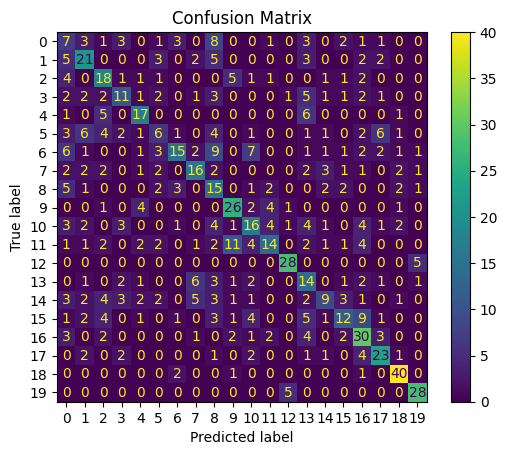

In [21]:
cm = confusion_matrix(y_val, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot() 
plt.title("Confusion Matrix")
plt.show()

 ---
### <center> 3. Result
 ---

- Build the function to capture the faces from the test image.

In [92]:

def crop_faces(image_path, save_path=None, visualize=False):

    # Load the YOLOv8-face model
    face_detection_model = YOLO("yolov8n-face.pt")

    # Load an image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Transform to RGB


    # Run inference
    results = face_detection_model.predict(img, conf=0.5)

    cropped_faces = []

    # Extract bounding boxes
    for result in results:
        boxes = result.boxes  # Bounding box outputs

        # Loop over detected faces
        for box in boxes:
            # Get coordinates (in pixel values)
            x1, y1, x2, y2 = map(int, box.xyxy[0])

            # Crop faces
            face_crop = img_rgb[y1:y2, x1:x2]
            cropped_faces.append(face_crop)

            # Get confidence score
            confidence = box.conf[0].item()

            # Draw the bounding box
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add confidence text
            label = f"Face: {confidence:.2f}"
            cv2.putText(img_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    if visualize:
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.show()

    return cropped_faces

- Build the function to make the prediction


In [102]:
def predict_faces(faces):
  features = np.array(extract_landmark(faces))
  normalized_features = np.array([compute_face_distances(x) for x in features])
  pred_face = clf.best_estimator_.predict(normalized_features)

  # Print faces with labels
  for f, label, landmark in zip(faces,pred_face, features):
    plt.imshow(f)
    plt.axis('off')
    for i in range(68):  # 68 landmark points
        x, y = landmark[i]
        plt.scatter(x, y, c='red', s=10)  # Plot each landmark
    print(person_label_dict[label])
    plt.show()

  return pred_face

- Finally, fill the attendance sheet with the input images.


0: 448x640 12 faces, 56.6ms
Speed: 8.3ms preprocess, 56.6ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


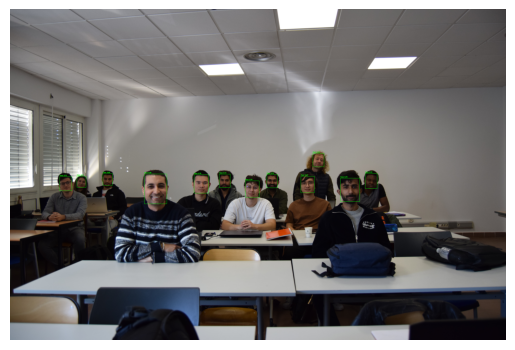

Juliana


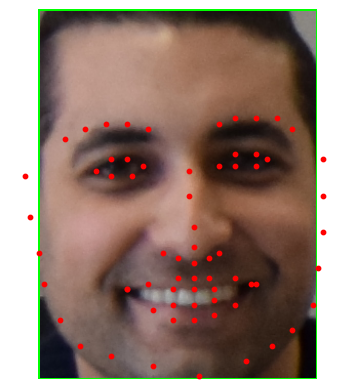

Usman


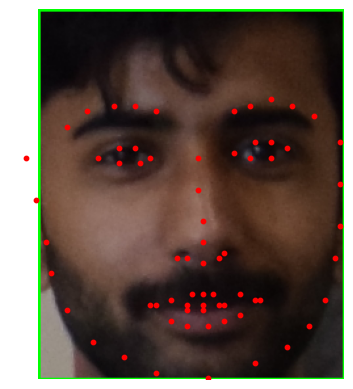

Nabila


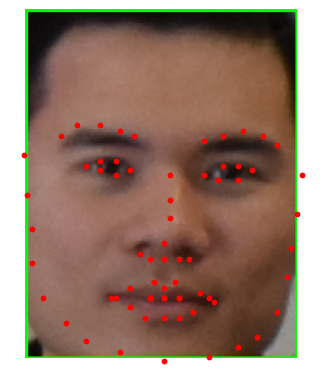

Melissa


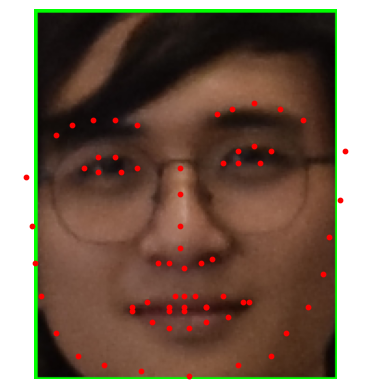

Nestor


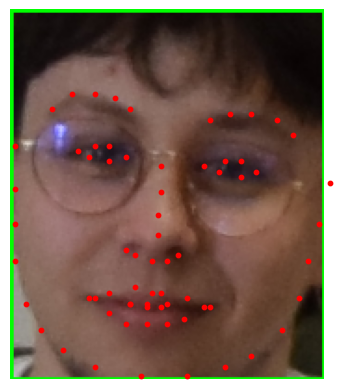

Melissa


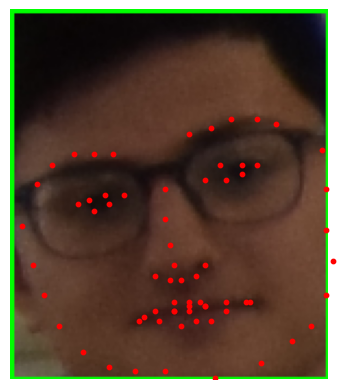

Usman


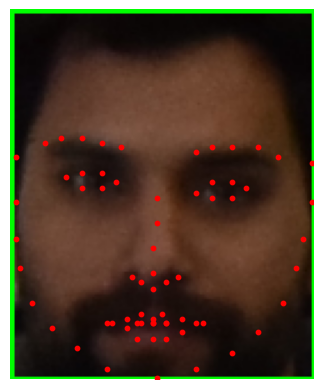

Tuan


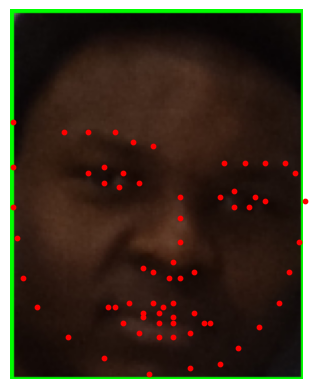

Nestor


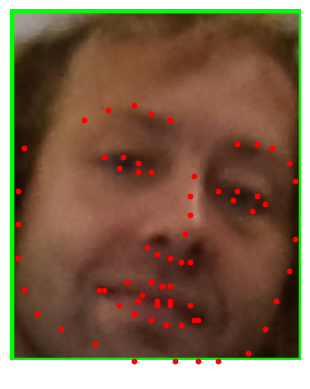

Melissa


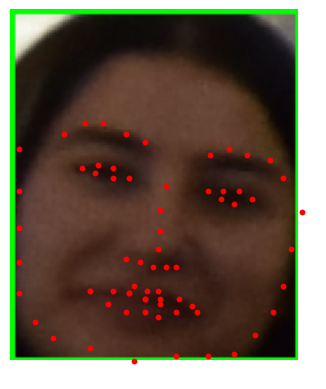

Melissa


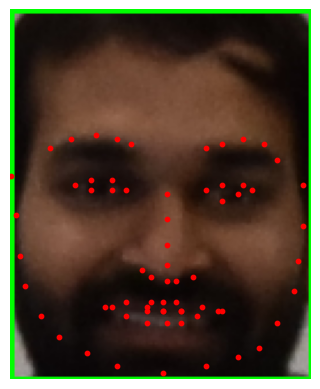

Youssef


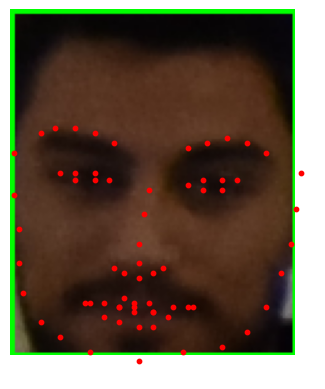

        Name  Attendance
0     Abinav         0.0
1      Arion         0.0
2      Dialo         0.0
3        Eli         0.0
4     Gerard         0.0
5       Hadi         0.0
6     Hasham         0.0
7     Hassan         0.0
8     Ismail         0.0
9    Juliana         1.0
10   Melissa         1.0
11    Nabila         1.0
12    Nestor         1.0
13      Tuan         1.0
14  Tuan Anh         0.0
15     Ubaid         0.0
16     Usman         1.0
17   Youssef         1.0
18     Zahid         0.0
19      Zeev         0.0


In [106]:
def attendance_sheet(img_path):
  faces = crop_faces(image_path = img_path, visualize=True)
  p_faces = predict_faces(faces)

  attendances = np.zeros(shape=(len(person_label_dict.keys())))
  attendances[p_faces] = 1
  df = pd.DataFrame({'Name': list(person_label_dict.values()), 'Attendance': attendances})
  print(df)

attendance_sheet( r'C:\Users\Admin\Master Program\Projects\Project_2\DATA ML-DL project n°02\1.JPG')

- From that result, we can see that the correct prediction rate is pretty low: 4/12. Only correct predictions are: Youssef, Melissa, Nestor and Usman

 ---
### <center> 4. Task outcomes and Conclusion
 ---

- The accuracy of the model pretty low, the reason is facial landmark points could be change if the same person express different emotions.
- The improvement is collecting more data with different expressions for each people in class. 